# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
# вероятности классов в вершине: 8/10 и 2/10
ps = np.array([0.8, 0.2])
# считаем энтропию
h = -sum(ps*np.log(ps))
round(h, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
# вероятности классов для каждой из вершин
p_rm = np.array([0.8, 0.2])
p_rl = np.array([1, 0])
p_rr = np.array([0, 1])

# считаем индекс джини для каждой вершины
h_rm = sum(p_rm*(1-p_rm))
h_rl = sum(p_rl*(1-p_rl))
h_rr = sum(p_rr*(1-p_rr))

# подставляем в формулу
q = h_rm - (0.8 * h_rl) - (0.2 * h_rr)
round(q, 2)

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
# значения переменной
r = np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
# находим предсказание по формуле
yr = (1 / len(r)) * sum(r)
yr

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # преобразуем в np.array target_vector и feature_vector
    feature_vector = np.array(feature_vector)
    target_vector = np.array(target_vector)

    # создадим вспомогательный датафрем со значениями признака и целевой переменной
    df = pd.concat([pd.Series(feature_vector), pd.Series(target_vector)], keys = ['feature_vector','target_vector'], axis=1)
    # и отсортируем по значениям признака
    df_sorted = df.sort_values(by='feature_vector')

    # если признак не категориальный
    if feature_type == 'real':

        # обрабатываем none в данных
        if None in feature_vector:
            # все индексы, где есть none
            inds_none = np.where(feature_vector == None)[0]
            # оставшиеся индексы
            inds_not_none = np.where(feature_vector != None)[0]
            # находим среднее объектов не None типа
            average = sum(feature_vector[inds_not_none]) / len(feature_vector[inds_not_none])
            # заменяем none на среднее других
            feature_vector[inds_none] = average

        # находим все возможные значения порогов
        a1 = np.array(sorted(np.unique(feature_vector)))
        a2 = np.array(sorted(np.unique(feature_vector)))[1:]
        thresholds = (a1[:-1] + a2) / 2

        # здесь храним переменные, которые потом будем возвращать
        best_threshold = 0
        best_gini = 0
        best_q = 0
        ginis = []

        # если классификация
        if task == 'classification':
            # считаем вероятности каждого из классов в вершине
            p_rm = np.unique(target_vector, return_counts=True)[1] / len(target_vector)
            all_values = np.unique(target_vector, return_counts=True)[0]

            # создаем словарь из всех значений классов и вероятностей этих классов
            di_rm = dict(zip(all_values, p_rm))

            # и джини
            h_rm = sum(p_rm*(1-p_rm))

            # затем для каждого возможного порога
            for t in thresholds:
                # находим объекты в левой и правой вершинах
                left = np.array(df_sorted[df_sorted['feature_vector'] < t]['target_vector'])
                right = np.array(df_sorted[df_sorted['feature_vector'] >= t]['target_vector'])

                # создаем словари со всеми значениями классов и нулями
                di_rl_zeros = dict(zip(all_values, np.zeros(len(all_values))))
                di_rr_zeros = dict(zip(all_values, np.zeros(len(all_values))))

                # список уникальных значений классов в левой и правой вершинах
                left_values = np.unique(left, return_counts=True)[0]
                right_values = np.unique(right, return_counts=True)[0]

                # вероятности каждого из классов в левой и правой вершинах
                p_rl_f = np.unique(left, return_counts=True)[1] / len(left)
                p_rr_f = np.unique(right, return_counts=True)[1] / len(right)

                # соединяем в словарь вероятности и значения классов
                di_rl = dict(zip(left_values, p_rl_f))
                di_rr = dict(zip(right_values, p_rr_f))

                # добавляем с учетом отсутствующих в вершине классов
                di_rl_zeros.update(di_rl)
                di_rr_zeros.update(di_rr)

                # считаем вероятности каждого из классов с учетом нулевых
                p_rl = np.fromiter(di_rl_zeros.values(), dtype=float)
                p_rr = np.fromiter(di_rr_zeros.values(), dtype=float)

                # считаем джини в левой и правой вершинах
                h_rl = sum(p_rl*(1-p_rl))
                h_rr = sum(p_rr*(1-p_rr))

                # считаем критерий информативности и добавляем в список
                q = h_rm - (len(left) / len(target_vector) * h_rl) - (len(right) / len(target_vector) * h_rr)
                ginis.append(q)

                # если полученное значение больше лучшего (ищем максимум)
                if q > best_q:
                    # запоминаем данные
                    best_q = q
                    best_gini = q
                    best_threshold = t

            return thresholds, ginis, best_threshold, best_gini
        # если регрессия
        else:
            # считаем дисперсию ответов
            y_rm = sum(target_vector) / len(target_vector)
            h_rm = sum((target_vector - y_rm)**2) / len(target_vector)

            # для каждого порога
            for t in thresholds:
                # определяем объекты в левой и правой вершинах
                left = np.array(df_sorted[df_sorted['feature_vector'] < t]['target_vector'])
                right = np.array(df_sorted[df_sorted['feature_vector'] >= t]['target_vector'])

                # считаем дисперсию для левой и правой вершины
                y_rl = sum(left) / len(left)
                h_rl = sum((left - y_rl)**2) / len(left)

                y_rr = sum(right) / len(right)
                h_rr = sum((right - y_rr)**2) / len(right)

                # считаем критерий информативности и добавляем список
                q = h_rm - (len(left) / len(target_vector) * h_rl) - (len(right) / len(target_vector) * h_rr)
                ginis.append(q)

                # сравниваем с предыдущими значениями
                if q > best_q:
                    best_q = q
                    best_gini = q
                    best_threshold = t

            return thresholds, ginis, best_threshold, best_gini

    # если категориальный признак
    else:

        # обрабатываем пропуски в данных
        if None in feature_vector:
            # находим индексы пропусков
            inds_none = np.where(feature_vector == None)[0]
            # и не пропусков
            inds_not_none = np.where(feature_vector != None)[0]
            # будем заменять пропуски самым часто встречающимся значением
            mc = Counter(feature_vector[inds_not_none]).most_common(1)
            feature_vector[inds_none] = mc

        best_threshold = 0
        best_gini = 0
        best_q = 0
        ginis = []

        # определяем пороги
        thresholds = np.unique(feature_vector)

        # остальное -- почти как в классификации
        # считаем вероятности классов
        p_rm = np.unique(target_vector, return_counts=True)[1] / len(target_vector)
        all_values = np.unique(target_vector, return_counts=True)[0]

        di_rm = dict(zip(all_values, p_rm))

        # и критерий джини
        h_rm = sum(p_rm*(1-p_rm))

        # для каждого порога
        for t in thresholds:
            # определяем объекты в левой и правой вершинах
            left = target_vector[np.where(feature_vector == t)]
            right = target_vector[np.where(feature_vector != t)]

            # дальше, как и в классификации, считаем вероятности с учетом нулей
            di_rl_zeros = dict(zip(all_values, np.zeros(len(all_values))))
            di_rr_zeros = dict(zip(all_values, np.zeros(len(all_values))))

            left_values = np.unique(left, return_counts=True)[0]
            right_values = np.unique(right, return_counts=True)[0]

            p_rl_f = np.unique(left, return_counts=True)[1] / len(left)
            p_rr_f = np.unique(right, return_counts=True)[1] / len(right)

            di_rl = dict(zip(left_values, p_rl_f))
            di_rr = dict(zip(right_values, p_rr_f))

            di_rl_zeros.update(di_rl)
            di_rr_zeros.update(di_rr)

            p_rl = np.fromiter(di_rl_zeros.values(), dtype=float)
            p_rr = np.fromiter(di_rr_zeros.values(), dtype=float)

            # критерий джини
            h_rl = sum(p_rl*(1-p_rl))
            h_rr = sum(p_rr*(1-p_rr))

            # критерий информативности
            q = h_rm - (len(left) / len(target_vector) * h_rl) - (len(right) / len(target_vector) * h_rr)
            ginis.append(q)

            # сравниваем полученное значение с предыдущими
            if q > best_q:
                best_q = q
                best_gini = q
                best_threshold = t


        return thresholds, ginis, best_threshold, best_gini

Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
# ищем по функции пороги, значения критерия информативности, лучший порог и лучший критерий для MedInc
thresholds, ginis, best_threshold, best_gini = find_best_split(X['MedInc'], y, task='regression')

Text(0.5, 1.0, 'MedInc: gini by threshold')

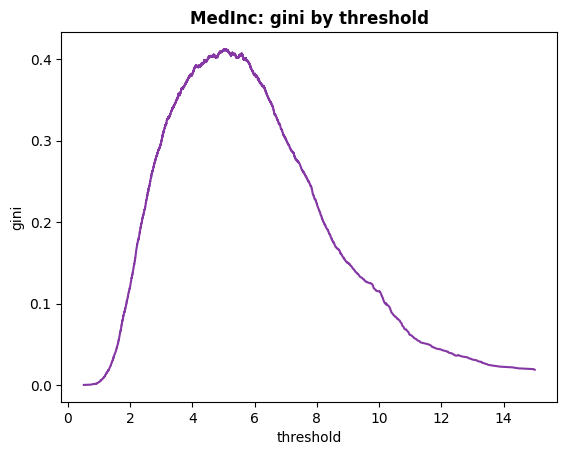

In [ ]:
# рисуем график зависимости значения критерия информативности от порогового значения
plt.plot(thresholds, ginis, color='#8537a4')

plt.xlabel('threshold')
plt.ylabel('gini')

plt.title('MedInc: gini by threshold', weight='bold')

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
# список всех признаков
features = list(X.columns.values)
# здесь будут значения для лучшего предиката
best_gini_first = 0
j = ''
t = 0
# для каждого признака
for feature in features:
    # определяем функцию на всей выборке от признака
    thresholds, ginis, best_threshold, best_gini = find_best_split(X[feature], y, task='regression')
    # если лучший критерий информативности получился больше предыдущих, то записываем параметры
    if best_gini > best_gini_first:
        best_gini_first = best_gini
        # признак
        j = feature
        # порог
        t = best_threshold

In [ ]:
# выводим лучший предикат для первой вершины
print(f'Лучший предикат: {j} < {t}')

Лучший предикат: MedInc < 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.** -- **cделала в предыдущей функции find_best_split**

- **Реализуйте метод оценки важности признаков.** -- **сделала в этой функции**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._splits = 0
        self._feature_splits = {}
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    # индексы объектов в левом и правом поддереве
                    split = np.where(feature_vector < threshold_best)[0]
                    not_split = np.where(feature_vector >= threshold_best)[0]
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = np.where(feature_vector == threshold_best)[0]
                    not_split = np.where(feature_vector != threshold_best)[0]
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best

        # если вершина нетерминальная, добавляем 1 к ее частоте встречаемости
        self._feature_splits[feature_best] += 1
        # добавляем также общее число сплитов к дереву
        self._splits += 1


        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}

        # начинаем дерево
        if self._tree == {}:
            self._tree = node

        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[not_split], sub_y[not_split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # смотрим на то, листовая ли вершина
        # если не листовая
        if node['type'] == 'nonterminal':
            # индекс признака, по которому делим
            feat = node['feature_split']
            # если вещественная переменная
            if self._feature_types[feat] == "real":
                # в левом поддереве
                if x[feat] < node['threshold']:
                    return self._predict_node(x, node['left_child'])
                # или правом
                else:
                    return self._predict_node(x, node['right_child'])
            # если категориальная переменная
            elif self._feature_types[feat] == "categorical":
                # левое поддерево
                if x[feat] == node['category_split']:
                    return self._predict_node(x, node['left_child'])
                # правое поддерево
                else:
                    return self._predict_node(x, node['right_child'])
            else:
                raise ValueError
        # если листовая вершина, возвращаем класс
        else:
            return node['class']

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # создаем нулевые частоты встречаемости в нелистовых вершинах для каждого признака
        self._feature_splits = dict.fromkeys(list(range(X.shape[1])), 0)

        # делаем фит для узла (дерева)
        self._fit_node(X, y, self._tree)

        # высчитываем итоговые важности признаков по следующей формуле
        # для каждого признака важность равна отношению количества сплитов с этим признаком на общее количество сплитов
        self._feature_importances = dict(zip(list(range(X.shape[1])), np.fromiter(self._feature_splits.values(), dtype=float) / self._splits))

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=9ecf6c71869fd80c96181f3ced30d815098ede096fd0f0cf04b7d1ec60bff999
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
# бибилиотеки для построения графиков
import matplotlib.gridspec as gridspec
import itertools

In [ ]:
# скачиваем файл
import wget

url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv'
filename = wget.download(url)

In [ ]:
# смотрим на данные
df = pd.read_csv(filename)
df.sample(4)

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
233,233,0.830,0.44,0.49,0.91,0.66,1
42,42,0.140,0.49,0.55,0.29,0.60,1
232,232,0.510,0.40,0.40,0.59,0.23,0
44,44,0.115,0.35,0.65,0.27,0.04,0


In [ ]:
# делим данные на Х и у
X = df.iloc[:, 1:6]
y = df.iloc[:, -1]

Text(0.5, 1.0, 'features: gini by threshold')

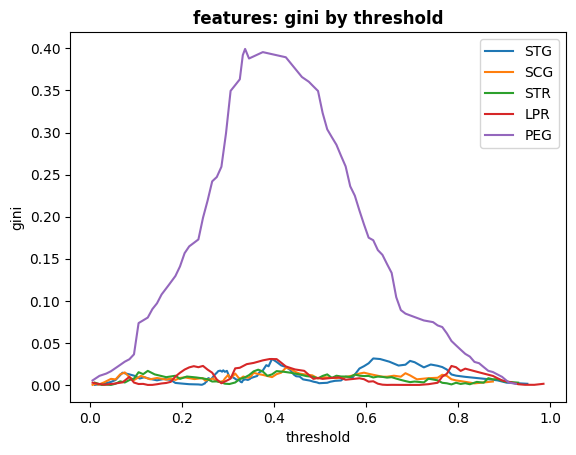

In [ ]:
# к каждому признаку применяем find_best_split
for x in X:
    thresholds, ginis, best_threshold, best_gini = find_best_split(X[x], np.array(y), task='classification')
    # рисуем график зависимости критерия информативности в завивимости от порога
    plt.plot(thresholds, ginis, label=x)

# добавляем легенду, названия осей и графика
plt.legend()

plt.xlabel('threshold')
plt.ylabel('gini')

plt.title('features: gini by threshold', weight='bold')

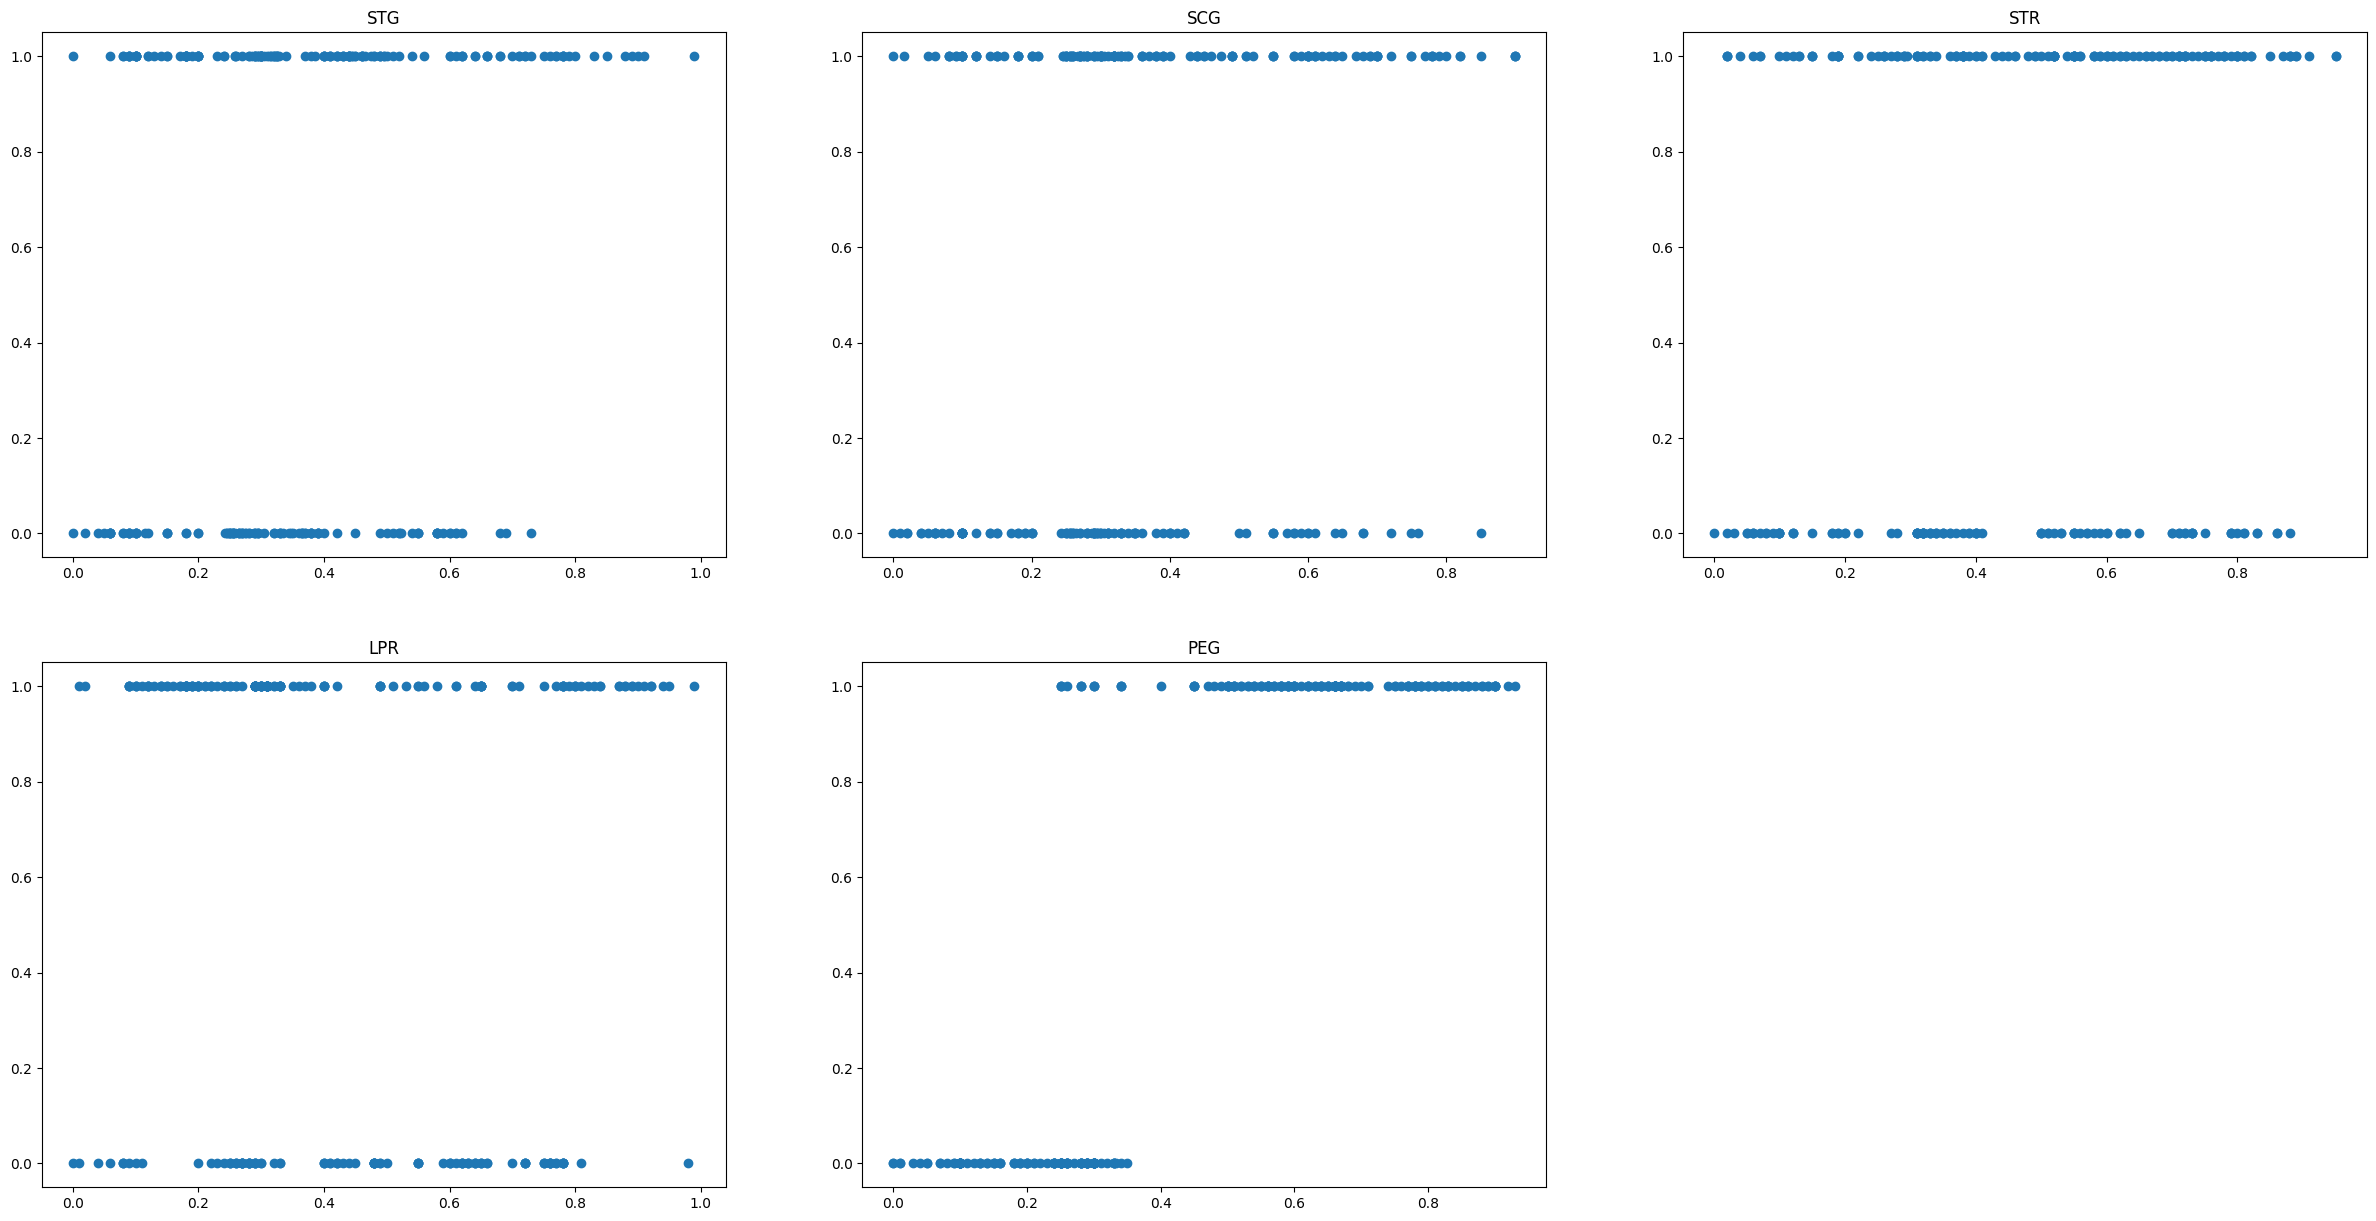

In [ ]:
# задаем сетку
gs = gridspec.GridSpec(2, 3)

# задаем размер общего графика
fig = plt.figure(figsize=(30,15))

# для каждого признака
for x, grd in zip(X, itertools.product([0, 1, 2], repeat=2)):
    # задаем subplot
    ax = plt.subplot(gs[grd[0], grd[1]])
    # строим картинку
    fig = plt.scatter(X[x], y)
    # добавляем название
    plt.title(x)
# выводим график
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

Исходя из кривых значений критерия информативности, лучше всего производить начальное деление выборки по признаку PEG. Поскольку алгоритм в начале выбирает такой признак, у которое значение критерия информативности, посчитанное по нашей формуле, максимальное. Остальные четыре признака находятся около нуля, значения их критерия информативности вне зависимости от выбранного порога будут сильно меньше макимального значения для PEG.

Кривая для хорошего признака (PEG) похожа на параболу: сначала значение критерия информативности невелико, потому что мы слишком мало объектов разделили. Затем в какой-то момент, когда выборка делится почти идеально, кривая достигает максимума. Затем дальнейшие разбиения будут хуже, потому что признаки другого классу будут уходить в левое поддерево, там энтропия будет становится выше.

Кривые для плохих признаков слишком близки к нулю. Вне зависимости от порога, в левой и в правой вершинах после разделения будет примерно одинаковое соотношение классов (как в родительской вершине).

Эти кривые соотносятся с диаграммами рассеяния. Для признака PEG она достаточно четко (с некоторыми немногочисленными исключениями) делит подвыборку на два класса. В остальных же случаях мы видим большие зоны пересечения классов: при многих значениях переменной объекты относятся как к положительному, так и к отрицательному классу примерно равновероятно

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
# импортируем энкодер
from sklearn.preprocessing import LabelEncoder

In [ ]:
# скачиваем данные
!pip install ucimlrepo

In [ ]:
# все еще скачиваем данные
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

In [ ]:
# преобразовываем y
y = y.replace('e', 1)
y = y.replace('p', 0)
y

,poisonous
0,0
1,1
2,1
3,0
4,1
...,...
8119,1
8120,1
8121,1
8122,0


In [ ]:
# остальные столбцы в Х
X = X.iloc[:, 1:]

In [ ]:
# кодируем переменные
le = LabelEncoder()
df_le = X.copy()

for x in X:
    df_le.loc[:, x] = le.fit_transform(df_le.loc[:, x])
df_le

,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,2,4,1,6,1,0,1,4,0,2,...,2,7,7,0,2,1,4,2,3,5
1,2,9,1,0,1,0,0,4,0,1,...,2,7,7,0,2,1,4,3,2,1
2,2,8,1,3,1,0,0,5,0,1,...,2,7,7,0,2,1,4,3,2,3
3,3,8,1,6,1,0,1,5,0,2,...,2,7,7,0,2,1,4,2,3,5
4,2,3,0,5,1,1,0,4,1,2,...,2,7,7,0,2,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,2,4,0,5,0,0,0,11,0,4,...,2,5,5,0,1,1,4,0,1,2
8120,2,4,0,5,0,0,0,11,0,4,...,2,5,5,0,0,1,4,0,4,2
8121,2,4,0,5,0,0,0,5,0,4,...,2,5,5,0,1,1,4,0,1,2
8122,3,4,0,8,1,0,1,0,1,4,...,1,7,7,0,2,1,0,7,4,2


In [ ]:
# делим выборку на трейн и тест
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_le, y,
                                                    test_size=0.5,
                                                    random_state=42)

In [ ]:
# создаем дерево
tree = DecisionTree(feature_types=['categorical']*X.shape[1])

In [ ]:
# делаем фит
tree.fit(np.array(X_train), np.array(y_train).flatten())

In [ ]:
# посмотрим на важность признаков
tree._feature_importances

{0: 0.07142857142857142,
 1: 0.07142857142857142,
 2: 0.14285714285714285,
 3: 0.21428571428571427,
 4: 0.0,
 5: 0.0,
 6: 0.14285714285714285,
 7: 0.0,
 8: 0.0,
 9: 0.14285714285714285,
 10: 0.0,
 11: 0.07142857142857142,
 12: 0.0,
 13: 0.07142857142857142,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.07142857142857142,
 19: 0.0,
 20: 0.0}

In [ ]:
# смотрим на метрику accuracy
from sklearn.metrics import accuracy_score

y_pred_ts = tree.predict(np.array(X_test))
y_pred_tr = tree.predict(np.array(X_train))

print(f'Accuracy на обучающей выборке: {accuracy_score(y_pred_tr, y_train)}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_pred_ts, y_test)}')

Accuracy на обучающей выборке: 1.0
Accuracy на тестовой выборке: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
# импортируем нужное
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# скачиваем файл
url = 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/diabetes.csv'

filename = wget.download(url)

In [ ]:
# смотрим на данные
data = pd.read_csv(filename)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

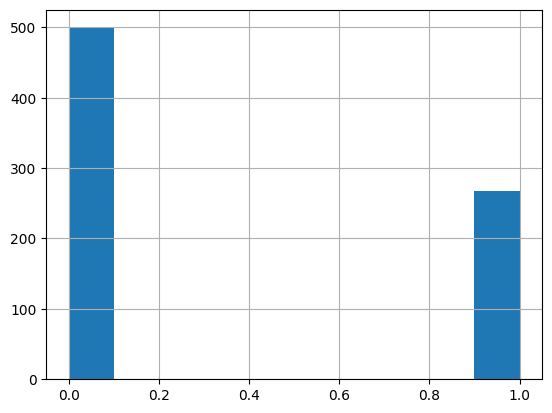

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
# делим на Х и у
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']

In [ ]:
# делим на три выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=0)
X_train, X_v, y_train, y_v = train_test_split(X_train, y_train,
                                              test_size=0.3,
                                              stratify=y_train,
                                              random_state=0)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
# будем сравнивать с этим значением
f1_best = 0
# здесь будут лучшие параметры
best_params = []
# возможные значения параметров
max_depths = np.arange(2, 101, 1)
min_samples_leafs = np.arange(1, 201, 1)
# смотрим параметры по циклу
for d in max_depths:
    for sl in min_samples_leafs:
        # обучаем дерево с подобранными параметрами
        tree = DecisionTreeClassifier(max_depth=d, min_samples_leaf=sl)
        tree.fit(X_train, y_train)
        pred_v = tree.predict(X_v)
        # смотрим, улучшилось ли f1
        f1 = f1_score(pred_v, y_v)
        if f1 > f1_best:
            f1_best = f1
            best_params = [d, sl]

In [ ]:
f1_best

0.6766917293233082

In [ ]:
best_params

[4, 62]

In [ ]:
# общая трейновая выборка
X_train_full = pd.concat([X_train, X_v], axis=0)
y_train_full = pd.concat([y_train, y_v], axis=0)

In [ ]:
# создаем дерево с лучшими параметрами
tree = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1])

In [ ]:
# обучаем дерево
tree.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=62)

In [ ]:
# предсказываем значения
y_pred = tree.predict(X_test)

In [ ]:
# смотрим на метрики
acc = accuracy_score(y_pred, y_test)
prec = precision_score(y_pred, y_test)
rec = recall_score(y_pred, y_test)
ra = roc_auc_score(y_pred, y_test)

print(f'accuracy: {acc}')
print(f'precision: {prec}')
print(f'recall: {rec}')
print(f'roc_auc: {ra}')

accuracy: 0.7229437229437229
precision: 0.6666666666666666
recall: 0.5934065934065934
roc_auc: 0.7002747252747253


Не очень получилась классификация :( Accuracy в самая лучшая, и то меньше 0.73

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
# базовые модели
base_tree = DecisionTreeClassifier(max_depth=best_params[0], min_samples_leaf=best_params[1])

# создаем бэггинг
bag = BaggingClassifier(base_tree, n_estimators=50)

In [ ]:
# обучаем бэггинг
bag.fit(X_train_full, y_train_full)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                   min_samples_leaf=62),
                  n_estimators=50)

In [ ]:
# предсказываем значения
y_pred_bag = bag.predict(X_test)

In [ ]:
# смотрим на метрики
acc = accuracy_score(y_pred_bag, y_test)
prec = precision_score(y_pred_bag, y_test)
rec = recall_score(y_pred_bag, y_test)
ra = roc_auc_score(y_pred_bag, y_test)

print(f'accuracy: {acc}')
print(f'precision: {prec}')
print(f'recall: {rec}')
print(f'roc_auc: {ra}')

accuracy: 0.7619047619047619
precision: 0.5679012345679012
recall: 0.696969696969697
roc_auc: 0.7424242424242424


Чуть лучше стала accuracy, recall, roc-auc. Но precision совсем упало: почти случайные 50%

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import cross_validate

In [ ]:
# сравниваем с этим значением
f1_best = 0
# здесь лучшие параметры
best_params = []
# возможные значения параметров
max_depths = np.arange(2, 101, 1)
min_samples_split = np.arange(2, 20, 1)
# проходимся по всем парам параметров
for d in max_depths:
    for sl in min_samples_split:
        # создаем случайный лес
        forest = RandomForestClassifier(n_estimators=50, max_depth=d, min_samples_split=sl, random_state=0)
        # здесь будут значения критерия на всей тестовых подвыборках при кросс-валидации
        scores = cross_validate(forest, X_train_full, y_train_full, cv=5,
                                scoring=('f1'))
        # усредняем значение критерия
        f1 = sum(scores['test_score']) / len(scores['test_score'])
        # изменяем значение, если оно увеличилось
        if f1 > f1_best:
            f1_best = f1
            best_params = [d, sl]

In [ ]:
f1_best

0.6354063510926256

In [ ]:
best_params

[15, 12]

In [ ]:
# создаем лес с подобранными параметрами
forest = RandomForestClassifier(n_estimators=50, max_depth=best_params[0], min_samples_split=best_params[1], random_state=0)

In [ ]:
# обучаем лес
forest.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=15, min_samples_split=12, n_estimators=50,
                       random_state=0)

In [ ]:
# предсказываем значения
y_pred_forest = forest.predict(X_test)

# и смотрим на метрики
acc = accuracy_score(y_pred_forest, y_test)
prec = precision_score(y_pred_forest, y_test)
rec = recall_score(y_pred_forest, y_test)
ra = roc_auc_score(y_pred_forest, y_test)

print(f'accuracy: {acc}')
print(f'precision: {prec}')
print(f'recall: {rec}')
print(f'roc_auc: {ra}')

accuracy: 0.7792207792207793
precision: 0.6049382716049383
recall: 0.7205882352941176
roc_auc: 0.7621346084446049


Качество примерно как при бэггинге, чуть лучше стало по всем метрикам

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

In [ ]:
# списки рок-ауков и числа деревьев
auc_rocs = []
n_estimatorss = np.arange(2, 301, 1)

for n in n_estimatorss:
    # создаем лес с параметрами в зависимости от числа деревьев
    forest = RandomForestClassifier(n_estimators=n, max_depth=best_params[0], min_samples_split=best_params[1], random_state=0)
    # обучаем, предсказываем, добавляем аук-рок в список
    forest.fit(X_train_full, y_train_full)
    y_pred = forest.predict(X_test)
    auc_rocs.append(roc_auc_score(y_pred, y_test))

Text(0.5, 1.0, 'auc-roc by number of estiamtors')

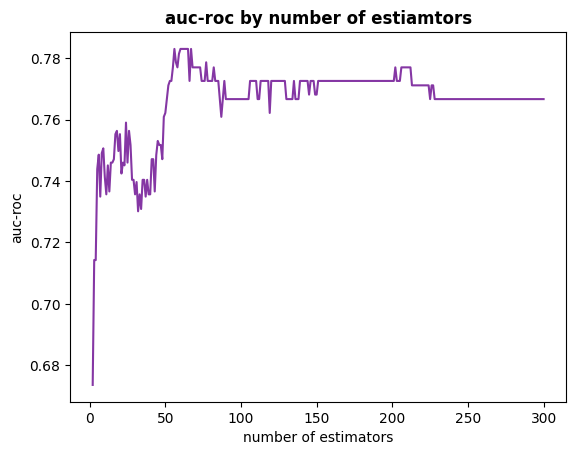

In [ ]:
# строим график, подписываем оси, добавляем название
plt.plot(n_estimatorss, auc_rocs, color='#8537a4')

plt.xlabel('number of estimators')
plt.ylabel('auc-roc')

plt.title('auc-roc by number of estiamtors', weight='bold')

Мы видим, что при очень маленьком количестве деревьев (до 10, наверное)значения рок-аука достаточно низние. При росте числа деревьев значение метрики растет, а потом останавливается и колеблется около одного значения. При добавлении числа деревьев не наблюдается переобучения, что видно по этой кривой!

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [ ]:
# обучаем лес с лучшими параметрами
forest = RandomForestClassifier(n_estimators=65, max_depth=best_params[0], min_samples_split=best_params[1], random_state=0)
forest.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=15, min_samples_split=12, n_estimators=65,
                       random_state=0)

In [ ]:
# смотрим на значимости признаков
importances = forest.feature_importances_
columns = X_train_full.columns
df = pd.concat([pd.Series(columns), pd.Series(importances)], axis=1)

Text(0, 0.5, 'importance')

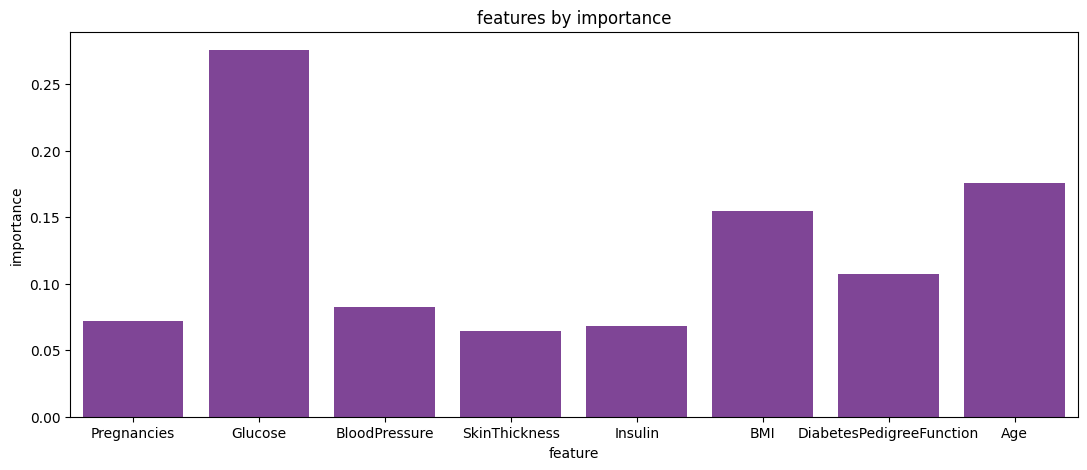

In [ ]:
# строим график значимости признаков
import seaborn as sns

fig, ax = plt.subplots(figsize=(13, 5))

ax = sns.barplot(df, x=0, y=1, color='#8537a4')
ax.set_title('features by importance')

plt.xlabel('feature')
plt.ylabel('importance')

Самый важный признак -- это glucose (наличие глюкозы в крови?), что достаточно логично, потому что она во многом может определять наличие диабета у человека